# Data Prep

In this Jupyter notebook, we will prepare training data for the SVM.
The big idea is to query the astronomicon database for a list of user's measurements of star clusters, 
and take the sky coordinates (RA, DEC) and the proper motion and distance constraints.
Then we will query the local Gaia database, and label all the stars either as cluster stars (0) or field stars (1).


## Setup MariaDB Connection

In [82]:
import json

import sqlalchemy as sa
import sqlalchemy.orm as orm

DB_BACKEND = "mysql+pymysql"
DB_HOST = "localhost"
DB_PORT = 3306
DB_USER = "root"
DB_PASS = ""


def import_labels():
    # create engine and session
    db_uri = '{}://{}:{}@{}:{}/{}'.format(DB_BACKEND, DB_USER, DB_PASS, DB_HOST, DB_PORT, "astronomicon")
    engine = sa.create_engine(db_uri)
    session = orm.scoped_session(orm.sessionmaker())
    session.configure(bind=engine)
    # query the database, get all observations
    obs_list = session.execute(
        sa.sql.text("SELECT cluster_id, ra, `dec`, score, constraints FROM astronomicon_submission")).all()
    # parse constraints of each observation
    parsed_obs_list = []
    for obs in obs_list:
        cluster_id, ra, dec, score, constraints = obs
        constraints = json.loads(constraints)
        distance_range = (constraints["distance"]["min"], constraints["distance"]["max"])
        pm_ra_range = (constraints["pm_ra"]["min"], constraints["pm_ra"]["max"])
        pm_dec_range = (constraints["pm_dec"]["min"], constraints["pm_dec"]["max"])
        parsed_obs_list.append(
            {"cluster_id": cluster_id, "ra": ra, "dec": dec, "score": score, "distance_range": distance_range,
             "pm_ra_range": pm_ra_range, "pm_dec_range": pm_dec_range})

    # remove duplicates
    parsed_obs_list.sort(
        key=lambda x: x["cluster_id"] * 10 - x["score"])  # sort by cluster_id with score as a tiebreaker
    unique_obs_list = []
    max_id = None
    max_count = 0
    count = 1
    for obs in parsed_obs_list:
        if len(unique_obs_list) == 0 or unique_obs_list[-1]["cluster_id"] != obs["cluster_id"]:
            unique_obs_list.append(obs)
            count = 1
            # print(unique_obs_list[-1])
        else:
            count += 1
        if count >= max_count:
            max_count = count
            max_id = obs["cluster_id"]
            
    most_observed_list = [obs for obs in parsed_obs_list if obs["cluster_id"] == max_id]
    return unique_obs_list, most_observed_list


obs_list, most_observed_list = import_labels()

## Pick a cluster from the list

In [84]:
index = 0

cluster = obs_list[index]
print(cluster)

cluster = most_observed_list[0]
print(cluster)

{'cluster_id': 3, 'ra': 92.27, 'dec': 24.34, 'score': 0.171668, 'distance_range': (0.77, 1), 'pm_ra_range': (1.67, 2.85), 'pm_dec_range': (-3.52, -2.3)}
{'cluster_id': 148, 'ra': 106.73, 'dec': -10.12, 'score': 0.432043, 'distance_range': (0.92, 1.59), 'pm_ra_range': (-2.47, 0.64), 'pm_dec_range': (-2.4, 0.87)}


## Query Gaia Database

In [85]:
data_dir = "/Users/reedfu/Skynet/astromancer-server/data/gaia_clusters_photometry.sqlite"

import math
import sqlite3
from numpy import arcsin, cos, deg2rad, rad2deg, sin


def local_get_data(query_range):
    try:
        dec = float(query_range['dec'])
        ra = float(query_range['ra'])
        r = float(query_range['radius'])
    except:
        raise Exception({"error": "Input invalid type"})
    if not 0 <= ra < 360:
        raise Exception({'error': 'Expected RA in the range [0, 360)'})
    if not -90 <= dec < 90:
        raise Exception({'error': 'Expected Dec in the range [-90, +90]'})
    if not 0 < r < 90:
        raise Exception({'error': 'Expected query radius in the range (0, 90)'})

    # Compute the RA/Dec query ranges; handle poles and RA=0/360 wrap
    dec_min, dec_max = dec - r, dec + r
    if dec_min < -90:
        # South Pole in FOV, use the whole RA range
        where = 'dec <= ?'
        args = (dec_max,)
    elif dec_max > 90:
        # North Pole in FOV, use the whole RA range
        where = 'dec >= ?'
        args = (dec_min,)
    else:
        # See http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates
        dra = rad2deg(arcsin(sin(deg2rad(r)) / cos(deg2rad(dec))))
        ra_min, ra_max = ra - dra, ra + dra
        if ra_max >= ra_min + 360:
            # RA spans the whole 360 range
            where = 'dec >= ? and dec <= ?'
            args = (dec_min, dec_max)
        elif ra_min < 0:
            # RA range encloses RA=0 => two separate RA ranges:
            # ra_min + 360 <= ra <= 360 and 0 <= ra <= ra_max
            where = '(ra >= ? or ra <= ?) and dec >= ? and dec <= ?'
            args = (ra_min + 360, ra_max, dec_min, dec_max)
        elif ra_max > 360:
            # RA range encloses RA=360 => two separate RA ranges:
            # ra_min <= ra <= 360 and 0 <= ra <= ra_max - 360
            where = '(ra >= ? or ra <= ?) and dec >= ? and dec <= ?'
            args = (ra_min, ra_max - 360, dec_min, dec_max)
        else:
            # RA range fully within [0, 360)
            where = 'ra >= ? and ra <= ? and dec >= ? and dec <= ?'
            args = (ra_min, ra_max, dec_min, dec_max)
    sqlite_filename = data_dir
    conn = sqlite3.connect(sqlite_filename)
    try:
        # Query RA/Dec region(s) using constraints defined above (should be
        # fast thanks to the indexes) in a subquery; the outer query returns
        # only sources within the circle of radius r using the haversine
        # formula, which is more accurate for small distances
        cur = conn.cursor()
        conn.create_function('asin', 1, math.asin)
        conn.create_function('sqrt', 1, math.sqrt)
        conn.create_function('sin', 1, math.sin)
        conn.create_function('cos', 1, math.cos)
        conn.create_function('radians', 1, math.radians)
        conn.create_function('pow', 2, math.pow)
        sources = cur.execute(
            'select * from (select * from clusters where ' + where +
            ') where asin(sqrt(pow(sin(radians(dec - ?)/2), 2) + '
            'pow(sin(radians(ra - ?)/2), 2)*cos(radians(dec))*?)) <= ?',
            args + (dec, ra, cos(deg2rad(dec)), deg2rad(r) / 2)
        ).fetchall()
    except Exception as e:
        raise Exception({'error': "Cannot Pull GAIA Database"})
    finally:
        conn.close()
    # Output sources in CSV
    # for source in sources:
    # source_id, ra, dec, r, pmra, pmdec
    # print(','.join(str(x) for x in source))
    return sources


def import_astrometry(ra, dec, radius=0.01, output=False):
    archive_data = local_get_data({'ra': ra, 'dec': dec, 'radius': radius})
    while len(archive_data) < 15000:
        radius += 0.01
        tmp = local_get_data({'ra': ra, 'dec': dec, 'radius': radius})
        if len(tmp) > 5000:
            break
        archive_data = tmp
    print("ra: {}, dec: {}, radius: {}, #stars: {}".format(ra, dec, radius, len(archive_data)))
    result = []
    for i in range(len(archive_data)):
        result.append({
            'id': archive_data[i][0],
            'ra': archive_data[i][1],
            'dec': archive_data[i][2],
            'pmra': archive_data[i][4],
            'pmdec': archive_data[i][5],
            'bp-rp': archive_data[i][7] - archive_data[i][8] if archive_data[i][7] is not None and archive_data[i][8] is not None else None,
        })
    if output:
        return np.array([[entry['ra'], entry['dec'], entry['pmra'], entry['pmdec']] for entry in result]) 
    return result


data = import_astrometry(cluster["ra"], cluster["dec"])

ra: 106.73, dec: -10.12, radius: 0.21000000000000005, #stars: 4877


## Data Preview

A 2D plot of the proper motion space is shown, along with the boundary provided by a user. 
Helps to visualize and eyeball if the label is good.


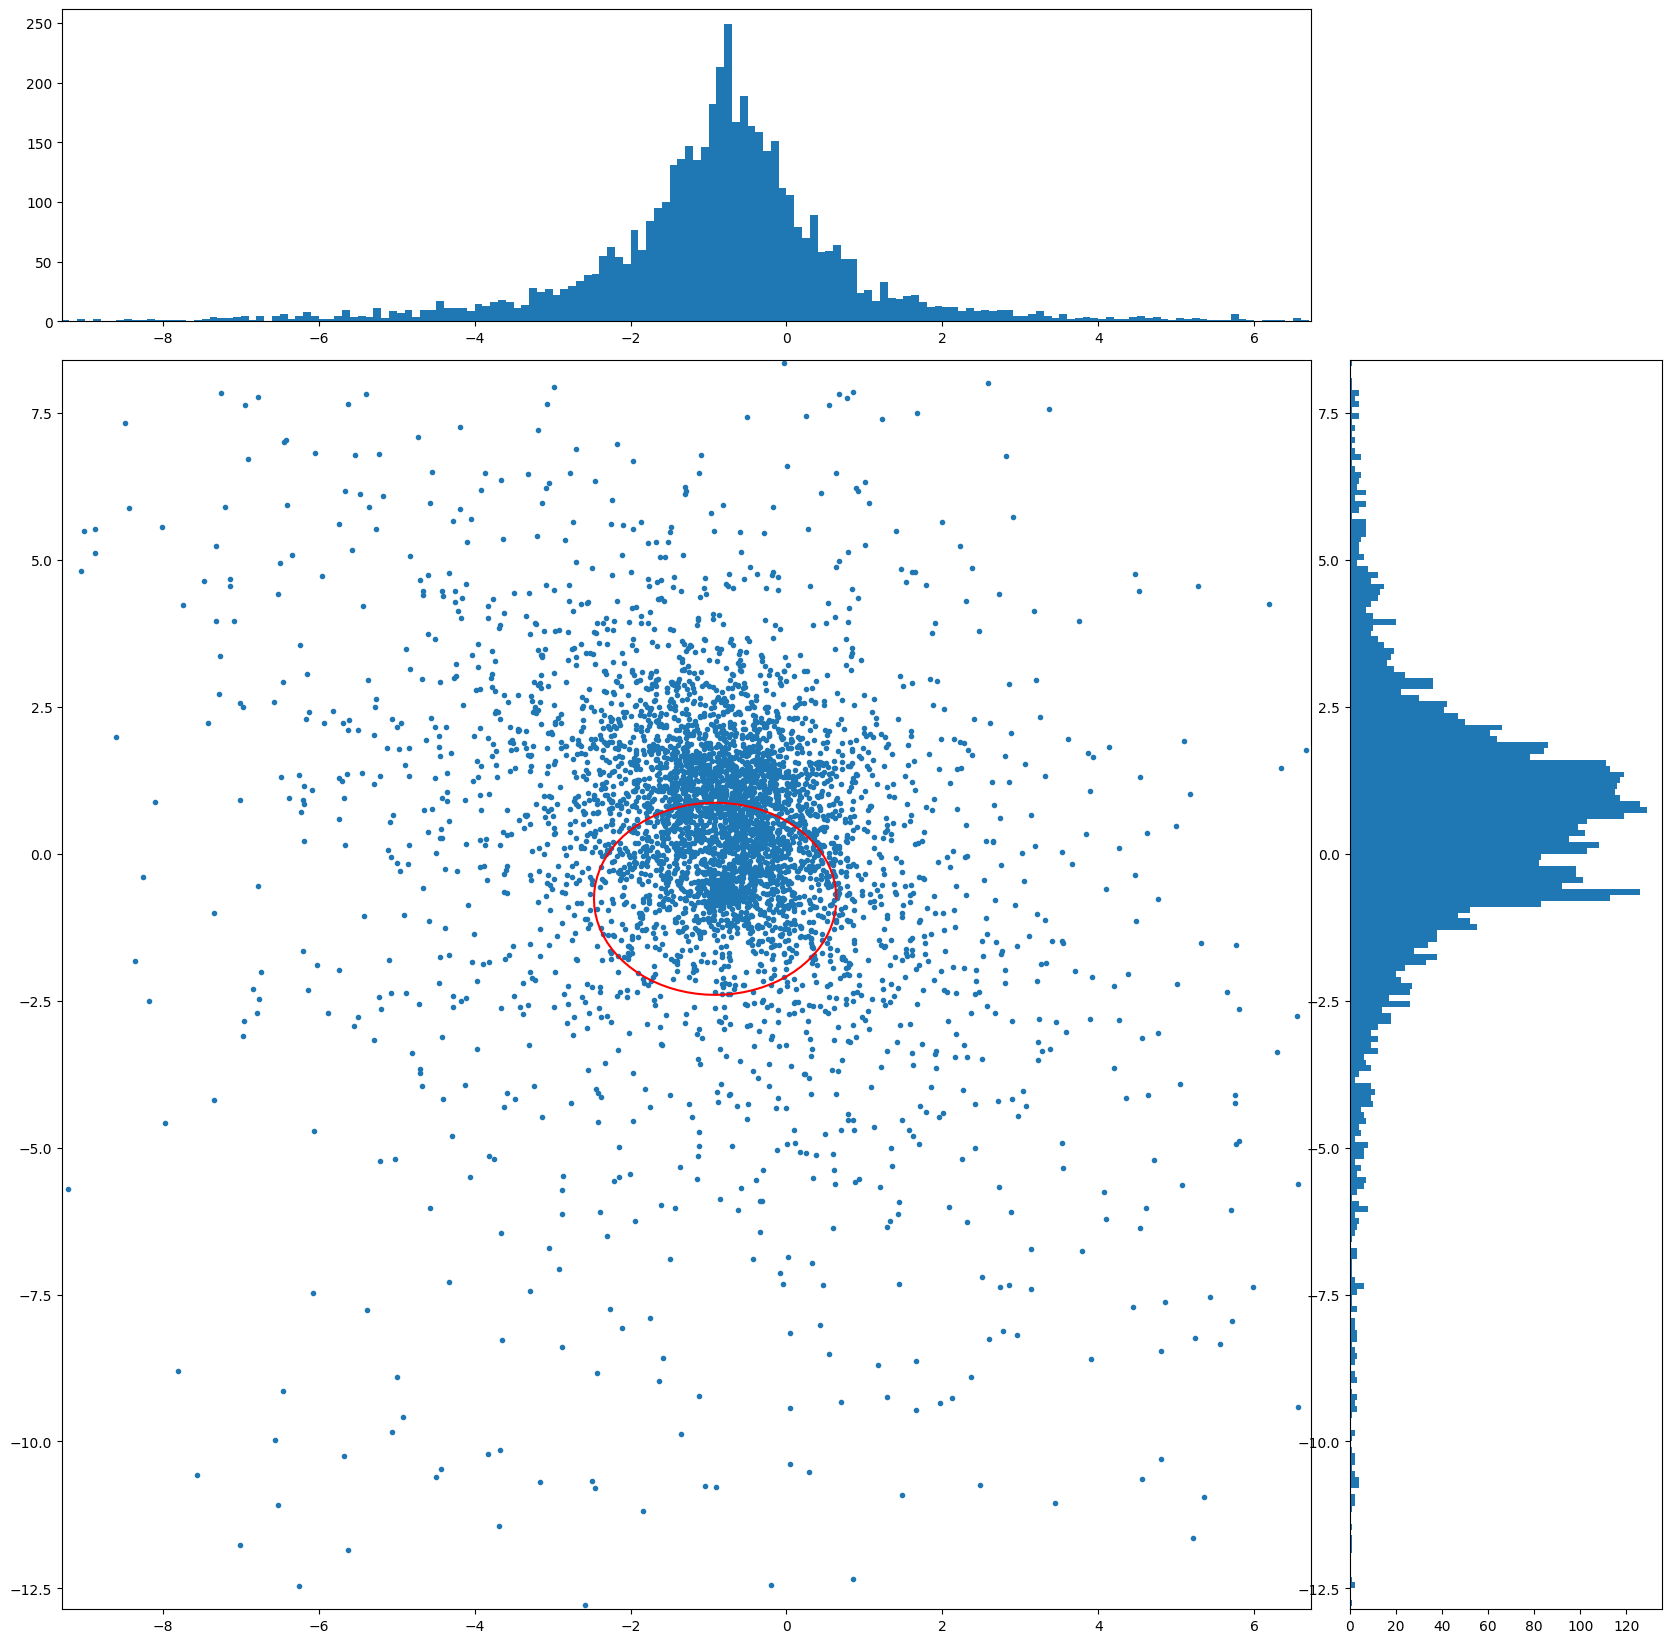

In [86]:
from astromancerpy.plot import plot_pm_histogram

plot_pm_histogram(cluster, data)


## Labeling

Label the stars as either cluster stars (1) or field stars (0) based on the boundary provided by the user.

TODO: Add the exact formula for determine if a star is inside the boundary.

In [74]:
import numpy as np

def label_stars(_cluster, _data):
    pmra_min = _cluster["pm_ra_range"][0]
    pmra_max = _cluster["pm_ra_range"][1]
    pmdec_min = _cluster["pm_dec_range"][0]
    pmdec_max = _cluster["pm_dec_range"][1]
    a = (pmra_max - pmra_min) / 2
    b = (pmdec_max - pmdec_min) / 2
    center_pmra = (pmra_max + pmra_min) / 2
    center_pmdec = (pmdec_max + pmdec_min) / 2
    result = []
    for i in range(len(_data)):
        pm_ra = _data[i]['pmra']
        pm_dec = _data[i]['pmdec']
        c = math.pow((pm_ra - center_pmra) / a, 2)
        label = 0
        if c < 1:
            dec_diff = b * math.sqrt(1 - c)
            if center_pmdec - dec_diff <= pm_dec <= center_pmdec + dec_diff:
                label = 1
        result.append([data[i]['ra'], data[i]['dec'], pm_ra, pm_dec, label]) # TODO: Figure out what other features to include
    return np.array(result)

labeled_data = label_stars(cluster, data)    

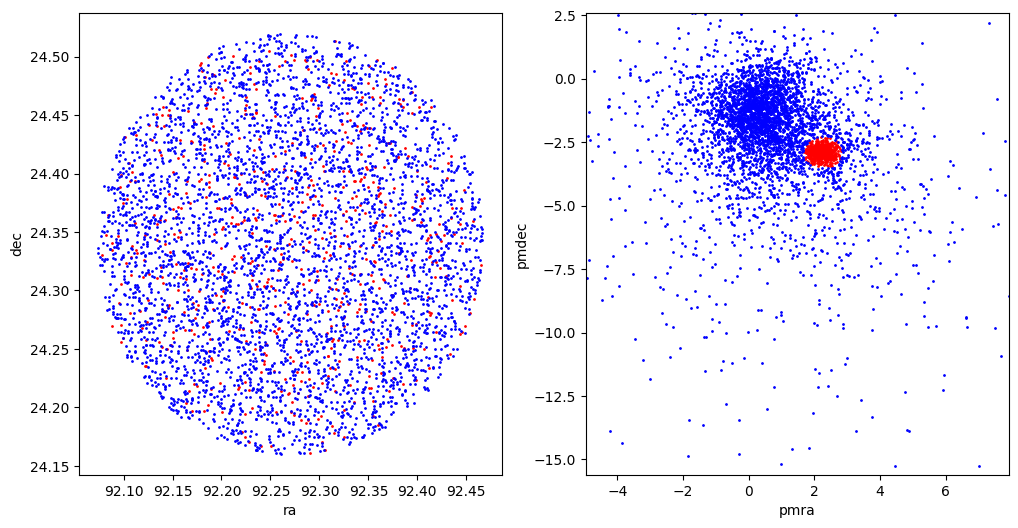

In [75]:
from astromancerpy.plot import plot_cluster

plot_cluster(labeled_data)

## Save Data

In [76]:
np.save("data/{}.npy".format(cluster["cluster_id"]), np.array(labeled_data))
np.save("data/{}-raw.npy".format(cluster["cluster_id"]), import_astrometry(cluster['ra'], cluster['dec'], 2, True))

ra: 92.27, dec: 24.34, radius: 2, #stars: 114799


## Save Most Observed Cluster

In [81]:
from sklearn.model_selection import ShuffleSplit

most_observed_cluster = most_observed_list[0]
most_observed_astrometry = import_astrometry(most_observed_cluster["ra"], ["dec"])
ss = ShuffleSplit(len(most_observed_list), test_size=0.2, random_state=69)
most_observed_astrometry_list =ss.get_n_splits(most_observed_astrometry)
print(most_observed_astrometry_list[0])
# for i in range(len(most_observed_list)):
#     obs = most_observed_astrometry_list[i]
#     astrometry = most_observed_astrometry_list[i]
#     obs_labeled_data = labeled_data(obs, astrometry)
    

Exception: {'error': 'Input invalid type'}